# GBM with Parameter Tuning (Without Red + Horizontal Inclination) 

[I 2024-06-21 10:38:46,114] Trial 1 finished with value: 0.752784113779686 and parameters: {'n_estimators': 180, 'max_depth': 16, 'learning_rate': 0.038033002349480524, 'subsample': 0.773331859169347, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.752784113779686.
[I 2024-06-21 10:49:47,361] Trial 2 finished with value: 0.7493962162887428 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.017671206382803246, 'subsample': 0.696742611535009, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 1 with value: 0.752784113779686.
[I 2024-06-21 12:04:17,667] Trial 3 finished with value: 0.746176036495371 and parameters: {'n_estimators': 141, 'max_depth': 11, 'learning_rate': 0.018980328436849683, 'subsample': 0.6699848507177615, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 0.752784113779686.
[I 2024-06-21 12:52:08,140] Trial 4 finish

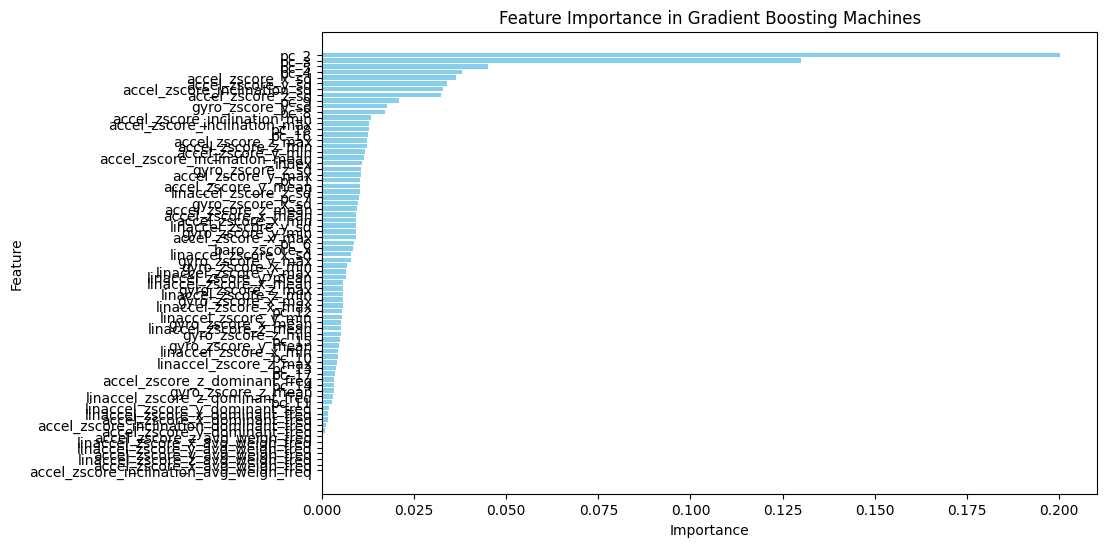

In [0]:
!pip install optuna 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
import optuna

# Load the dataset
full_data = pd.read_parquet("full_dataset.parquet.gzip")
full_data = full_data[full_data["SM_platform"] != "Red"]

# Split the dataset into training and testing sets
random.seed(51)
testing_categories = [1, 2, 3, 4, 5, 6]
random.shuffle(testing_categories)

testing_set = [f"{platform}{number}" for platform, number in zip(full_data["SM_platform"].unique(), testing_categories)]
testing_df = full_data[full_data["source_name"].isin(testing_set)]
training_df = full_data[~full_data["source_name"].isin(testing_set)]

# Only select standardized columns
columns_to_select = [col for col in full_data.columns if 'zscore' in col] + ["SM_platform", "index"] + [col for col in
                                                                                                        full_data.columns
                                                                                                        if 'pc' in col]
training_df = training_df.loc[:, columns_to_select]
testing_df = testing_df.loc[:, columns_to_select]

# Separate features and target
X_train = training_df.drop(columns=["SM_platform"])
y_train = training_df["SM_platform"]
X_test = testing_df.drop(columns=["SM_platform"])
y_test = testing_df["SM_platform"]

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


# Optuna objective function for hyperparameter tuning
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    gbm = GradientBoostingClassifier(**param, random_state=42)
    gbm.fit(X_train, y_train_encoded)
    y_pred = gbm.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred)

    return accuracy


# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
gbm_model = GradientBoostingClassifier(**best_params, random_state=42)
gbm_model.fit(X_train, y_train_encoded)

# Make predictions
y_pred = gbm_model.predict(X_test)

# Decode the predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test_labels, y_pred_labels)}")
print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, y_pred_labels))

# Feature importance
importances = gbm_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head())

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Machines')
plt.gca().invert_yaxis()
plt.show()

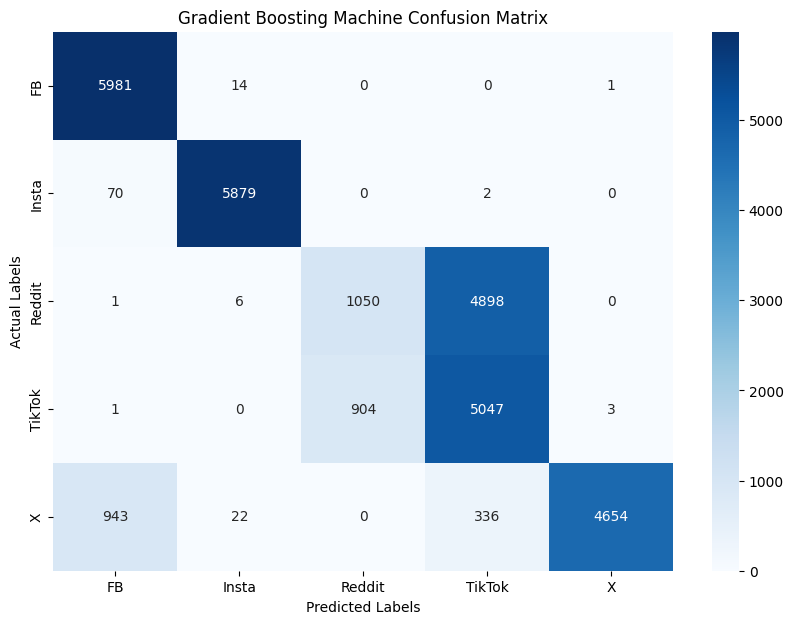

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)

# Convert to DataFrame for better labeling in seaborn heatmap
cm_df = pd.DataFrame(cm,
                     index=[i for i in label_encoder.classes_], 
                     columns=[i for i in label_encoder.classes_])

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Gradient Boosting Machine Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5ea8f536-739f-4c50-806e-84490cb7d5e0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>